# CogPonder: An Interoperable Model of Response Times in Cognitive Tasks

We are interested in a model of response time that is interoperable in human data and computational agents.

Inspired by [PonderNet](https://arxiv.org/abs/2107.05407), this notebook demonstrates CogPonder, a differentiable model that produces human-like speed-accuracy in decision making tasks.

The model iterates over a recurrent decision network, terminating only when it reaches a halting step. The network is trained to 1) maximize decision accuracy and 2) maximize the similarity between the human response time distribution and the halting steps of the network.


## Tasks

### N-back Task

N-back is a cognitive test commonly used to tap into working memory. In this task, human subjects are presented with a sequence of symbols, and are asked to respond with the "target" button whe the current symbol matches the one from N steps earlier in the sequence. The load factor N can be adjusted the difficulty of the task.

Here, we use a mock 2-back dataset to evaluate the architecture. The mock dataset includes, for each subject, trial-level $X$ (symbol), $is_targets$ (or $y$; whether it was a target), $responses$, and $response\_times$.


### Decision Model

We want to learn a supervised approximation of the $X \to y$ as follows:
$
f: X,h_n \mapsto \tilde{y},h_{n+1}, \lambda_n
$

where $X$ and $y$ denote recent stimulus and responses, $\lambda_n$ is the halting probability at step $n$, and $h_{n}$ is the latent state of the decision model. The learning process continues for a maximum of $N_{max}$ steps. The duration of each step is in fact a hyperparameter of the model, but for brevity is considered 100ms. ($\lambda_n$) is the halting probability in step $n$ (given a Bernoulli distribution), and $p_n$ is the probability of halting at step $n$, which imply that in all the previous steps it did not halt. The halting probability is a function of the latent state $h_n$, $lambda_n$, and the current symbol $X$.

For the N-back task, we define X as a moving window of recent N+1 symbols, e.g., [A, B, C] and [B, C, D], ...; and $y$ is either NON_MATCH (False or 0) or MATCH (True or 1).

### Output

The *CogPonder* network produces $y\_steps$, $p\_halts$, $halt\_steps$ for each item in the batch. Batch items are the trials in the N-back task.


### Criterion

$L = L_{rec} + L_{reg_{RT}}$


In [60]:
%reload_ext autoreload
%autoreload 3

import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar, EarlyStopping

from cogponder import CogPonderNet
from cogponder import ICOM, NBackMockDataset
from cogponder import NBackMockDataModule

# CONSTANTS
N_STIMULI = 6
MAX_RESPONSE_STEP = 100
MAX_EPOCHS = -1

In [62]:
# load the dataset
data = NBackMockDataModule()

# define the underlying decision model
decision_model = ICOM(n_inputs=N_STIMULI+1, n_channels=N_STIMULI, n_outputs=2)

# the pondering model
model = CogPonderNet(
    decision_model,
    embeddings_dim=N_STIMULI,
    max_response_steps=MAX_RESPONSE_STEP)

# define the training parameters
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    log_every_n_steps=10,
    auto_scale_batch_size=True,
    callbacks=[
        RichProgressBar(),
        EarlyStopping(monitor='val_loss', patience=10, mode='min')
    ])

# train the model on the dataset
trainer.fit(model, datamodule=data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name           ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ decision_model │ ICOM       │    138 │
│ 1 │ halt_node      │ Sequential │      7 │
└───┴────────────────┴────────────┴────────┘

Trainable params: 145                                                                                              
Non-trainable params: 0                                                                                            
Total params: 145                                                                                                  
Total estimated model params size (MB): 0

Output()

In [63]:
# DEBUG

import torch

X_train, _, _, rt_train = data.dataset[data.train_dataset.indices]
X_test, _, _, rt_test = data.dataset[data.test_dataset.indices]

with torch.no_grad():
    model.eval()
    rt_train_pred = model(X_train)[2].detach()
    rt_test_pred = model(X_test)[2].detach()

    # DEBUG report the ground truth and predicted response times
    print('TRUE TRAIN:', rt_train.detach().tolist(), '\nPRED TRAIN:',  rt_train_pred.tolist())
    print('TRUE TEST:', rt_test.detach().tolist(), '\nPRED TEST:',  rt_test_pred.tolist())

# DEBUG report medians
# rt_train_pred.median(), rt_train.float().median()
# rt_test_pred.median(), rt_test.float().median()


TRUE TRAIN: [2, 5, 3, 2, 3, 2, 2, 2, 6, 2, 3, 2, 6, 2, 4, 6, 5, 2, 3, 7, 4, 3, 2, 2, 3, 3, 3, 3, 5, 2, 3, 3, 3, 2, 2, 2, 4, 2, 2, 3, 3, 9, 2, 2, 2, 3, 3, 8, 2, 3, 3, 4, 3, 7, 7, 2, 5, 2, 3, 7, 14, 2, 2, 4, 4, 6, 2, 4, 2, 6, 4, 3, 5, 4, 3, 2, 4, 4] 
PRED TRAIN: [3, 2, 1, 2, 4, 4, 3, 3, 2, 4, 4, 2, 2, 1, 1, 2, 2, 2, 4, 6, 1, 8, 5, 2, 3, 4, 4, 2, 6, 4, 4, 2, 4, 4, 2, 1, 1, 2, 3, 6, 4, 1, 5, 4, 2, 2, 2, 1, 4, 3, 6, 1, 1, 2, 2, 4, 3, 3, 2, 2, 4, 1, 5, 4, 2, 2, 7, 3, 3, 3, 3, 4, 6, 2, 1, 2, 2, 5]
TRUE TEST: [5, 2, 2, 4, 3, 2, 3, 2, 2, 2, 2, 4, 3, 4, 7, 2, 4, 3, 2, 4] 
PRED TEST: [0, 3, 2, 3, 1, 2, 3, 3, 1, 4, 1, 0, 1, 2, 2, 4, 1, 1, 2, 3]


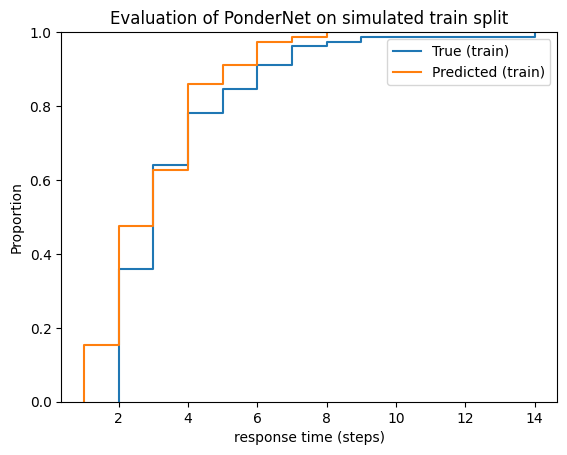

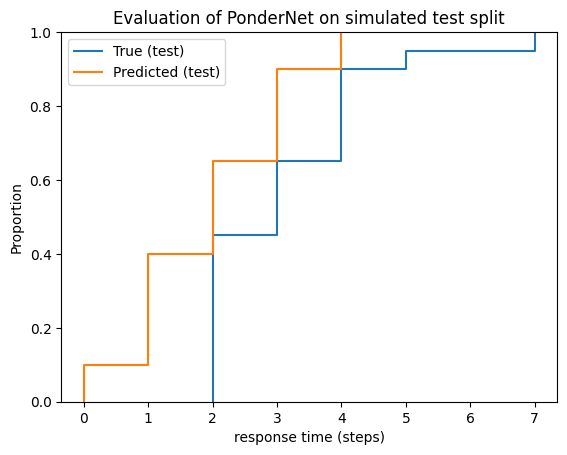

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.ecdfplot(rt_train.detach(), label='True (train)')
sns.ecdfplot(rt_train_pred.detach(), label='Predicted (train)')

plt.title('Evaluation of PonderNet on simulated train split')
plt.xlabel('response time (steps)')

plt.legend()
plt.show()

sns.ecdfplot(rt_test.detach(), label='True (test)')
sns.ecdfplot(rt_test_pred.detach(), label='Predicted (test)')

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()

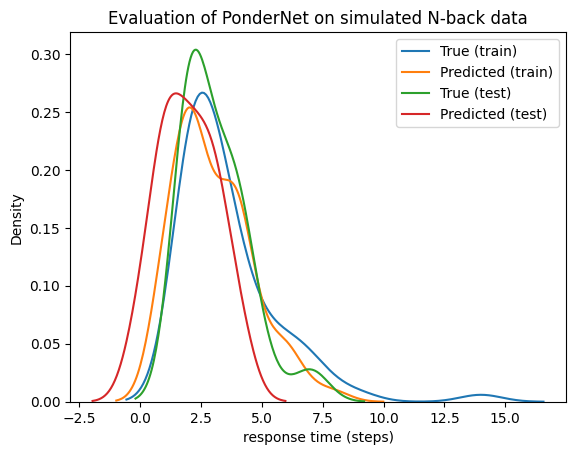

In [67]:

sns.kdeplot(rt_train.detach(), label='True (train)')
sns.kdeplot(rt_train_pred.detach(), label='Predicted (train)')

sns.kdeplot(rt_test.detach(), label='True (test)')
sns.kdeplot(rt_test_pred.detach(), label='Predicted (test)')


plt.title('Evaluation of PonderNet on simulated N-back data')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()